# Homework 04: Unsupervised Learning
_According to the **Academic Integrity Policy** of this course, all work submitted for grading must be done individually, unless otherwise specified. While we encourage you to talk to your peers and learn from them, this interaction must be superficial with regards to all work submitted for grading. This means you cannot work in teams, you cannot work side-by-side, you cannot submit someone else’s work (partial or complete) as your own. In particular, note that you are guilty of academic dishonesty if you extend or receive any kind of unauthorized assistance. Absolutely no transfer of program code between students is permitted (paper or electronic), and you may not solicit code from family, friends, or online forums. Other examples of academic dishonesty include emailing your program to another student, copying-pasting code from the internet, working in a group on a homework assignment, and allowing a tutor, TA, or another individual to write an answer for you.  **Note that using AI-generated code (Google Gemini, ChatGPT, copilot, etc) verbatim in your submission also comes under academic dishonesty, as discussed in the first lecture. You may solicit help from Generative AI tools to assist you in the assignment, but not to do the assignment for you**. **Academic dishonesty is unacceptable, and penalties range from failure to expulsion from the university; cases are handled via the official student conduct process described at https://dos.uic.edu/conductforstudents.shtml**._

## Due Date
This assignment is due at **11:59 PM, November 23, 2024**.

## Submission Instructions
**Lookout for a Piazza post before the deadline**

## Autograder
TBD


Run the following cell to check if the notebook is being run over Google Colab and mount your Gdrive:

In [ ]:
try:
    from google.colab import drive
    running_colab = True
except:
    print("Not Running on Google Colab!")
    running_colab = False

if running_colab:
    drive.mount('/content/drive')
    %cd /content/drive/My Drive/hw4colab

Mounted at /content/drive
/content/drive/My Drive/hw4colab


## Data : Sample of 5k ArXiv Paper Abstracts
For this homework we will work on a dataset of 5k paper abstracts uploaded to the online scholarly article repository [arXiv](https://arxiv.org/). The .csv is bundled with this homework titled "abstracts_5k.csv". Each row corresponds to a paper and contains the following fields:

1. `id` : Unique ID assigned to each submission on arXiv formatted as `YYMM.NNNNN` (YY - two characters for year, MM - two characters for month, NNNNN - upto 5 characters for serial number of submission). Older submissions have the following format: `subject/YYMMNNN` e.g. `cs/0511035`

2. `submitter`: Name of the user uploading the paper

3. `authors`: Names of the authors

4. `comments`: Comments made by the submitter about the paper during submission

5. `journal-ref`: Bibliographic reference to the article if it has been published in a journal

6. `doi`: Digital Object Identifier(s) of the article

7. `abstract`: Contents of the paper's abstract

8. `report-no`: Publication number assigned by the author's institution

9. `version`: List of versions of the paper on arXiv

As you can see, we have almost all metadata for each research paper submission EXCEPT for which subject it belongs to. Our goal with this homework will be to use unsupervised learning to discover what subjects are prevalent in the data using the contents of each paper's abstract using K-Means clustering.

Our pipeline will have the following stages:

* A. **Text Processing**: Clean up of the abstracts text data using the [nltk](http://www.nltk.org/genindex.html) package; this stage is identical to the previous homework and you are allowed to reuse your functions here.
* B. **Feature Construction**: Constructing feature vectors for our abstracts
* C. **Clustering**: Cluster the abstracts using the feature vectors
* D. **Visualization**: Visualize the obtained clusters

There are a total of 9 questions: 8 programming questions and 1 written question. Each one is marked with a big red question mark (?).

Since we are working with text data, we will be relying heavily on `nltk` and `sklearn`. For visualization, we will use a Python package called `WordCloud` in addition to `matplotlib`. Some of the packages have been imported below, rest will be installed via pip and imported later.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import sklearn
import re
import string
!pip install ipympl
%matplotlib widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 46.1 MB/s eta 0:00:00


In [ ]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("punkt_tab")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words("english")



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


<a id='stop_words'></a>

## A. Text Processing [10%]

Our focus will primarily be on textual data encoded in the paper abstracts, hence we will write a string of functions to process text data exactly as in homework 03. Each abstract is a raw string of characters, and our desired output from this stage will be a list of tokens that satifies the following criteria:

1. All tokens are in lower case
2. Order of tokens is preserved
3. Tokens are lemmatized: ignore exceptions thrown during the lemmatization process with nltk
4. Punctuations are stripped from all tokens
5. URLs must be completely removed
6. <mark>Inline LaTeX equations must be removed</mark> (character sequences enclosed within single '$' characters)
7. <mark>LaTeX Text Decorations must be removed</mark> (e.g. "\textit{euler}" becomes "euler", and "\underline{data science}" becomes "data science")

The last two highlighted criteria are different from what we did in HW3 since paper abstracts are usually submitted in LaTeX syntax which requires further processing. Python's regular expression package `re` will be useful for this as well. You will need to figure out the appropriate order to carry out operations according to the above criteria to avoid errors i.e. removing punctuations before math-mode equations or vice versa.  

Hints from HW3 for this section:
>You may find `string.punctuation` useful, to get hold of all punctuation symbols. Look for [regular expressions](https://docs.python.org/3/library/re.html) to capture patterns in the text. Your tokens must be of type `str`. Use `nltk.word_tokenize()` for tokenization once you have handled punctuation in the manner specified above.
>
>You would want to take a look at the `lemmatize()` function [here](https://www.nltk.org/_modules/nltk/stem/wordnet.html).
In order for `lemmatize()` to give you the root form for any word, you have to provide the context in which you want to lemmatize through the `pos` parameter: `lemmatizer.lemmatize>(word, pos=SOMEVALUE)`. The context should be the part of speech (POS) for that word. The good news is you do not have to manually write out the lexical categories for each word because [nltk.pos_tag()](https://www.nltk.org/book/ch05.html) will do this for you. Now you just need to use the results from `pos_tag()` for the `pos` parameter.
However, you can notice the POS tag returned from `pos_tag()` is in different format than the expected pos by `lemmatizer`.
> pos
(Syntactic category): n for noun files, v for verb files, a for adjective files, r for adverb files.
>
>You need to map these pos appropriately. `nltk.help.upenn_tagset()` provides description of each tag returned by `pos_tag()`.

<img src="https://upload.wikimedia.org/wikipedia/commons/0/02/Vraagteken.svg" width="50px" align="left" float="left" style="padding-left:30px;"/>

<br><br><br><br>

### Q1 : Cleaning Text I. [6%]:

In [ ]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Convert part of speech tag from nltk.pos_tag to word net compatible format
# Simple mapping based on first letter of return tag to make grading consistent
# Everything else will be considered noun 'n'
posMapping = {
# "First_Letter by nltk.pos_tag":"POS_for_lemmatizer"
    "N":'n',
    "V":'v',
    "J":'a',
    "R":'r'
}

# 5% Credits
def process(text, lemmatizer=nltk.WordNetLemmatizer()):

    """
    Normalizes case and handles punctuation

    Parameters
    ----------
    text: str:
        raw text
    lemmatizer: nltk.WordNetLemmatizer()
        an instance of a class implementing the lemmatize() method
        (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)

    Returns
    -------
    list(str)
        tokenized text
    """

    # [Your Code Starts Here]
    text = text.lower()

    # Step 2: Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Step 3: Remove inline LaTeX equations ($...$)
    text = re.sub(r'\$.*?\$', '', text)

    # Step 4: Remove LaTeX decorations (e.g., \textit{}, \underline{})
    text = re.sub(r'\\[a-zA-Z]+{(.*?)}', r'\1', text)

    # Step 5: Tokenize text
    tokens = word_tokenize(text)

    # Step 6: Remove punctuation and non-alphanumeric tokens
    tokens = [token for token in tokens if token.isalnum()]

    # Step 7: Perform POS tagging
    pos_tags = pos_tag(tokens)

    # Step 8: Lemmatization based on POS tags
    lemmatized_tokens = [
        lemmatizer.lemmatize(token, pos=posMapping.get(tag[0], 'n'))
        for token, tag in pos_tags
    ]

    return lemmatized_tokens


    # [Your Code Ends Here]

You should test your `process()` function at the bottom of the following code cell. We have provided portions of a few abstracts from the data as inputs to test with in order to get you started:

In [ ]:
input_1 = " Two-dimensional (2D) layered transition metal dichalcogenides \
              (TMDs) have\nemerged as promising materials for electronic, optoelectronic,\
               and valleytronic\napplications."

print(process(input_1))
# ['two', 'dimensional', '2d', 'layered', 'transition', 'metal', 'dichalcogenides',
#  'tmds', 'have', 'emerge', 'a', 'promising', 'material', 'for', 'electronic',
#  'optoelectronic', 'and', 'valleytronic', 'application']

input_2 = "  We solved analytically viscous two-dimensional (2D) fluid equations\
               for\naccretion and outflows in spherical polar coordinates ($r, \\theta, \\phi$)\
               and\nobtained explicitly flow variables in $r-$ and $\\theta -$directions\
               around\nblack holes (BHs)."

print(process(input_2))
# ['we', 'solve', 'analytically', 'viscous', 'two', 'dimensional', '2d', 'fluid',\
#  'equation', 'for', 'accretion', 'and', 'outflow', 'in', 'spherical', 'polar',\
#  'coordinate', 'and', 'obtain', 'explicitly', 'flow', 'variable', 'in',\
#  'direction', 'around', 'black', 'hole', 'bhs']

input_3 = "'  The pumping intensity (I) dependence of the photoluminescence (PL) spectra of\n\
            perfectly laterally two-dimensionally ordered SiGe quantum dots on Si(001)\n\
            substrates was studied. The PL results from recombinations of holes localized\
            \nin the SiGe quantum dots and electrons localized due to the strain field\
            in the\nsurrounding Si matrix. At approximately \
            I>3W/cm^2,\nadditional bands with a nearly quadratic \
            I dependence appear in the PL spectra "

print(process(input_3))
#['the', 'pump', 'intensity', 'i', 'dependence', 'of', 'the', 'photoluminescence',\
#  'pl', 'spectrum', 'of', 'perfectly', 'laterally', 'two', 'dimensionally', 'order',\
#  'sige', 'quantum', 'dot', 'on', 'si001', 'substrate', 'be', 'study', 'the', 'pl',\
#  'result', 'from', 'recombination', 'of', 'hole', 'localize', 'in', 'the', 'sige',\
#  'quantum', 'dot', 'and', 'electron', 'localize', 'due', 'to', 'the', 'strain', 'field',\
#  'in', 'the', 'surround', 'si', 'matrix', 'at', 'approximately', 'i3wcm2', 'additional',\
#  'band', 'with', 'a', 'nearly', 'quadratic', 'i', 'dependence', 'appear', 'in', 'the',\
#  'pl', 'spectrum']

# 1% Credit
# [Your Tests Start Here]



# [Your Tests End Here]


['2d', 'layered', 'transition', 'metal', 'dichalcogenides', 'tmds', 'have', 'emerge', 'a', 'promising', 'material', 'for', 'electronic', 'optoelectronic', 'and', 'valleytronic', 'application']
['we', 'solve', 'analytically', 'viscous', '2d', 'fluid', 'equation', 'for', 'accretion', 'and', 'outflow', 'in', 'spherical', 'polar', 'coordinate', 'and', 'obtain', 'explicitly', 'flow', 'variable', 'in', 'and', 'direction', 'around', 'black', 'hole', 'bhs']
['the', 'pump', 'intensity', 'i', 'dependence', 'of', 'the', 'photoluminescence', 'pl', 'spectrum', 'of', 'perfectly', 'laterally', 'order', 'sige', 'quantum', 'dot', 'on', 'si', '001', 'substrate', 'be', 'study', 'the', 'pl', 'result', 'from', 'recombination', 'of', 'hole', 'localize', 'in', 'the', 'sige', 'quantum', 'dot', 'and', 'electron', 'localize', 'due', 'to', 'the', 'strain', 'field', 'in', 'the', 'surround', 'si', 'matrix', 'at', 'approximately', 'i', 'additional', 'band', 'with', 'a', 'nearly', 'quadratic', 'i', 'dependence', 'ap

<img src="https://upload.wikimedia.org/wikipedia/commons/0/02/Vraagteken.svg" width="50px" align="left" float="left" style="padding-left:30px;"/>

<br><br><br><br>
### Q2 : Cleaning Text II. [4%]:

It's time now to load our dataset:

In [ ]:
abstracts = pd.read_csv("./abstracts_5k.csv", index_col=0)
abstracts.head()

id                    submitter  \
0         0804.0629                  Boaz Tsaban   
1         0908.3353      Fabio Giuseppe Pusateri   
2  quant-ph/0304129                     Mardoyan   
3        1605.06142               Nadine Fischer   
4  cond-mat/0602014  Anna Morozovska Nickolaevna   

                                             authors  \
0      Arkadius Kalka, Mina Teicher, and Boaz Tsaban   
1                                     Fabio Pusateri   
2      L.G. Mardoyan, L.S. Petrosyan, H.A. Sarkisyan   
3  Nadine Fischer, Stefan Prestel, Mathias Ritzma...   
4                  A. N. Morozovska and E.A. Eliseev   

                                            comments  \
0  Final version, accepted to Advances in Applied...   
1                                           19 pages   
2                                 8 pages, 5 figures   
3                                                NaN   
4                                25 pages, 7 figures   

                                       journal-ref  \
0  Advances in Applied Mathematics 49 (2012) 57-76   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                                              NaN   

                              doi  \
0       10.1016/j.aam.2012.03.001   
1                             NaN   
2      10.1103/PhysRevA.68.014103   
3  10.1140/epjc/s10052-016-4429-6   
4                             NaN   

                                            abstract  \
0    On March 2004, Anshel, Anshel, Goldfeld, and...   
1    We consider the interface problem between tw...   
2    The spherical wave functions of charge-dyon ...   
3    We present the first public implementation o...   
4    We have modified Landau-Khalatnikov approach...   

                                           report-no  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  CoEPP-MN-16-11, MCNET-16-13, SLAC-PUB-16529, N...   
4                                                NaN   

                         versions  
0  ['v1', 'v2', 'v3', 'v4', 'v5']  
1                          ['v1']  
2                          ['v1']  
3        ['v1', 'v2', 'v3', 'v4']  
4                          ['v1']

We will now use our `process()` function to convert abstracts from their raw textual form, to a list of processed tokens. The returned dataframe should have its `abstracts` column transformed with `process()` applied to each abstract text. All other columns and their order in the dataframe must remain unchanged.

**Note**: Original dataframe `abstracts` must not be altered

In [ ]:
# 3% Credit
def process_abstracts(df, lemmatizer=nltk.WordNetLemmatizer()):
    """
    Process all abstracts in the dataframe using calls to the process() function

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe object containing a column 'abstract'
    lemmatizer: nltk.WordNetLemmatizer
        An instance of the WordNetLemmatizer class implementing the lemmatize() method

    Returns
    -------
    pd.DataFrame
        Same as the dataframe 'df' except for the 'abstracts' column transformed
        from str to list(str) using function `process()`
    """

    # [Your Code Starts Here]
    df_processed = df.copy()

    # Apply the process function to each abstract
    df_processed['abstract'] = df_processed['abstract'].apply(lambda text: process(text, lemmatizer))

    return df_processed

    # [Your Code Ends Here]

You should test your `process_abstracts()` function below

In [ ]:
# 1% Credit
processed_abstracts = process_abstracts(abstracts)

## B. Feature Construction [20%]



After cleaning and processing the raw abstracts, we will compute a representation for each abstract that is appropriate for unsupervised learning, that is, a numeric representation that sufficiently encapsulates its contents. TF-IDF is a good candidate, we will use `TfidfVectorizer` to vectorize our abstracts.

Before we do that, however, we would like to get rid of any words that are irrelevant to our task. Stop words are an obvious choice. We will first write a function that takes as input a set of words and a list of tokens, and returns a list of tokens with the given set of words filtered out. Fill in the function `filter_words` below that takes as argument a list of tokens, a set of words to be filtered out, and returns a filtered list of tokens.

<img src="https://upload.wikimedia.org/wikipedia/commons/0/02/Vraagteken.svg" width="50px" align="left" float="left" style="padding-left:30px;"/>
<br><br><br><br>

### Q3 : Filtering out Irrelevant Words [10%]

In [ ]:
# 3% Credit
def filter_words(tokenized_text:list, words_to_filter:set):
    """
    Returns a tokens list with the words in `words_to_filter`
    filtered out

    Parameters
    ----------
    tokenized_text : list(str)
        List of text tokens
    words_to_filter : set(str)
        Set of words to filter out

    Returns
    -------
    list(str)
        List of text tokens with words in
        `words_to_filter` filtered out
    """

    # [Your Code Starts Here]

    # Hint: Use filter() - https://docs.python.org/3/library/functions.html#filter
    return [word for word in tokenized_text if word not in words_to_filter]

    # [Your Code Ends Here]




Fill in the following function `filter_words_in_series()` that uses `filter_words()` to filter words from a `pd.Series` object containing a list of lists of tokenized texts.

In [ ]:
# 3% Credit
def filter_words_in_series(tokenized_text_ser:pd.Series, words_to_filter:set):
    """
    Returns a `pd.Series` object containing a list of tokenized
    text with words in `words_to_filter` removed

    Parameters
    ----------
    tokenized_text_ser : pd.Series
        Series object containing a list of tokenized texts
    words_to_filter : set(str)
        Set of words to filter out

    Returns
    -------
    pd.Series
        Series object containing the list of tokenized texts
        with words in `words_to_filter` removed
    """


    # [Your Code Starts Here]
    return tokenized_text_ser.apply(lambda tokens: filter_words(tokens, words_to_filter))

    # [Your Code Ends Here]

We will now use these functions to filter out stop words from our data:

In [ ]:
df = pd.read_csv('./abstracts_5k.csv', index_col=0)
processed_abstracts = process_abstracts(df)
processed_abstracts["abstract"] = filter_words_in_series(processed_abstracts["abstract"], stopwords)

Scientific paper abstracts tend to be long, and may contain a large number of topic-agnostic words like "model", and "results". To further clean up our data, we will remove the top 25 most common words from all abstracts. Fill in the following function `top_25_hf_words()` that, given a `pd.Series` object containing a list of tokenized texts, returns the set of top 25 most occurring words across all texts:

In [ ]:
# 4% Credit
from collections import Counter
def top_25_hf_words(abstracts_ser:pd.Series):
    """
    Returns the top 25 most commonly occurring words
    across all abstracts in a series object containing
    a list of abstract texts

    Parameters
    ----------
    abstracts_ser : pd.Series
        Series objects containing a list of abstracts

    Returns
    -------
    set(str)
        Set of top 25 high frequency words
    """

    # [Your Code Starts Here]
    all_words = [word for abstract in abstracts_ser for word in abstract]
    word_counts = Counter(all_words)
    top_25_words = word_counts.most_common(25)
    return set(word for word, _ in top_25_words)

    # [Your Code Ends Here]

In [ ]:
print(top_25_hf_words(processed_abstracts["abstract"]))

{'function', 'two', 'field', 'theory', 'model', 'method', 'result', 'data', 'quantum', 'provide', 'paper', 'show', 'use', 'one', 'present', 'find', 'base', 'also', 'time', 'energy', 'problem', 'propose', 'system', 'study', 'state'}


Now we will use `filter_words_in_series()` to filter out the top 25 most common words from our data:

In [ ]:
processed_abstracts['abstract'] = filter_words_in_series(processed_abstracts["abstract"], top_25_hf_words(processed_abstracts["abstract"]))

The next step is to create feature vectors for each abstract.

<img src="https://upload.wikimedia.org/wikipedia/commons/0/02/Vraagteken.svg" width="50px" align="left" float="left" style="padding-left:30px;"/>
<br><br><br><br>

### Q4 : TF-IDF Vectorization [10%]
Fill in the following function `create_features_tfidf()` that takes as input a dataframe containing a column of tokenized texts named "abstract" and returns the TF-IDF feature matrix as well as the instance used for vectorization. Use [`sklearn.feature_extraction.text.TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Pass `min_df=2` to filter out words that occur in less than 2 documents i.e. in just one document. Also set `tokenizer` and `lowercase` appropriately. Leave all other optional parameters.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# 4% Credit
def create_features_tfidf(abstracts:pd.DataFrame):
    """
    Compute TF-IDF features for the abstracts dataset

    Parameters
    ----------
    abstracts : pd.DataFrame
        Dataframe with a column named 'abstract'
        containing list of abstracts

    Returns
    -------
    TfidfVectorizer()
        Instance of the class TfidfVectorizer
    scipy.sparse._csr_matrix
        TF-IDF feature matrix
    """

    # [Your Code Starts Here]
    abstracts_text = abstracts['abstract'].apply(lambda tokens: ' '.join(tokens))
    tfidf_vectorizer = TfidfVectorizer(lowercase=True, tokenizer=lambda x: x.split(), min_df=2)
    tfidf_matrix = tfidf_vectorizer.fit_transform(abstracts_text)

    return tfidf_vectorizer, tfidf_matrix



    # [Your Code Ends Here]

In [ ]:
# Correct unpacking order
tfidf_obj, tfidf_feats = create_features_tfidf(processed_abstracts)

# Now access the shape of the tfidf_feats (TF-IDF feature matrix)
print(tfidf_feats.shape)

# Convert the sparse matrix to a dense array for inspection
tfidf_dense = tfidf_feats.toarray()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5000, 9672)


### Dimensionality Reduction

Our TF-IDF vectors are very sparse (have a lot of zeroes) and very high-dimensional (~10000). Can you determine how sparse it is? Use the following formula to write a function `sparsity()` that returns a measure of the sparsity of a matrix:
$$ \text{Sparsity}(A) = \frac{|\{a_{ij}: a_{ij} = 0\}|}{n \times m}$$
Where $n$ is the number of rows and $m$ is the number of columns of the matrix $A$

In [ ]:
# 2% Credit
from scipy.sparse import csr_matrix
def sparsity(A:np.ndarray):
    """
    Determine the sparsity of a matrix
    by dividing the number of non-zero
    elements with the total number of
    elements of matrix `matrix`

    Parameters
    ----------
    A : np.ndarray
        Input matrix

    Returns
    -------
    float
        A measure of the sparsity of A
    """
    # [Your Code Starts Here]
    if hasattr(A, "count_nonzero"):
        non_zero_elements = A.count_nonzero()
        total_elements = A.shape[0] * A.shape[1]
    else:
        non_zero_elements = np.count_nonzero(A)
        total_elements = A.size
    return 1 - (non_zero_elements / total_elements)
    # [Your Code Ends Here]

Let's use `sparsity` to see how sparse our TF-IDF feature matrix is:

In [ ]:
print("Sparsity = ", sparsity(tfidf_feats))

Sparsity =  0.9949976220016543


If your function is correct, you will see that almost 99.5% of entries in our TF-IDF matrix are zero! Thankfully, we have `sklearn.decomposition.TruncatedSVD` to our rescue. This class implements a Singular-Value Decomposition for reducing dimensionality of sparse matrices, and is heavily employed with text data. Let us first import the class:

In [ ]:
from sklearn.decomposition import TruncatedSVD

Now we will write a function that instantiates this class to call its `fit_transform()` method performs SVD on the input matrix and returns the output. While instantiating `TruncatedSVD` you have the option to specify the dimensionality of your output feature matrix (i.e. the number of columns) by setting the `n_components` parameter (which is 2 by default). We will set `n_components` to a heuristically chosen value of 100, so that our output matrix has the shape $[5000 \times 100]$

In [ ]:
# 4% Credit
def reduce_tfidf_dimensions(feat_mat:np.ndarray, dim:int=100):
    """
    Reduce dimensionality of a sparse feature matrix as input

    Parameters
    ----------
    feat_mat:np.ndarray
        Sparse feature matrix
    dim:int
        Dimensionality of output feature matrix (i.e. number of
        columns)

    Returns
    -------
    np.ndarray
        Dense feature matrix
    """

    # [Your Code Starts Here]
    svd = TruncatedSVD(n_components=dim)
    reduced_matrix = svd.fit_transform(feat_mat)

    return reduced_matrix

    # [Your Code Ends Here]

Now we will compute our reduced TF-IDF feature matrix:

In [ ]:
red_tfidf_feats = reduce_tfidf_dimensions(tfidf_feats, 100)

Let us check the sparsity of the resultant matrix:

In [ ]:
print("Sparsity = ", sparsity(red_tfidf_feats))

Sparsity =  0.0


Now that we have sufficiently dense feature matrix, we will use it to cluster our data.

## C. Clustering [30%]



We are going to employ K-Means Clustering to place our abstracts into distinct groups in the feature space (Read more about K-Means clustering [here](https://scikit-learn.org/1.5/modules/clustering.html#k-means)). We will use [`sklearn.cluster.KMeans`](https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class for this which implements the K-Means clustering algorithm:

In [ ]:
from sklearn.cluster import KMeans

The `KMeans` class contains a number of helpful methods to fit a K-Means model on your data. Specifically helpful is the [`fit()`](https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit) that takes as argument the data `X`, and clusters the data according to the K-Means objective.

<img src="https://upload.wikimedia.org/wikipedia/commons/0/02/Vraagteken.svg" width="50px" align="left" float="left" style="padding-left:30px;"/>
<br><br><br><br>

### Q5 : Fitting K-Means [15%]

Fill in the following function `fit_k_means()` that takes as argument the precomputed feature matrix, an integer count of the number of clusters, an integer count `iteration` that specifies the number of training runs, and returns an array of labels specifying cluster indexes assigned to each of the abstract instances (in order). You must instantiate `KMeans` class imported above and call the `fit()` method to compute a clustering.

The K Means clustering algorithm is sensitive to initialization, therefore to avoid ill effects of bad initialization we must have multiple training runs and select the clustering that has the smallest cluster variation i.e. the smallest within-cluster-sum-of-squares or WCSS value:
$$\sum_k \sum_{i\in C_k}(x_i - \mu_k)^2$$
Where $k \in \{0, .., K-1\}$ is the cluster index, $C_k$ the associated cluster, $x_i$ the vector representation of the $i^{th}$ abstract (stored in the TF-IDF feature matrix), and $\mu_k$ the centroid of cluster $k$.

`fit_k_means()` must cluster the data with K Means `iterations` times, calculate the WCSS value for each fit, and choose the fit having the smallest WCSS value. The `KMeans` instance associated with the best clustering must be returned

**Hint**: `KMeans.inertia_`

In [ ]:
def fit_k_means(feat_mat:np.ndarray, cluster_count=5, iterations=5):
    """
    Fit the abstracts data feature vectors into `cluster_count`
    clusters using the K Means cluster algorithm & select
    the best clustering out of `iterations` number
    of clusterings

    Parameters
    ----------
    feat_mat : np.ndarray
        Feature matrix encoding feature vectors
        for all 5k abstracts
    cluster_count : int
        Number of distinct clusters
    iterations : int
        Number of training runs

    Returns
    -------
    sklearn.cluster.KMeans
        Instance of the sklearn.cluster.KMeans class
        representing the best clustering
    """

    # [Your Code Starts Here]
    best_kmeans = None
    lowest_wcss = float('inf')

    for i in range(iterations):

        kmeans = KMeans(n_clusters=cluster_count, init='k-means++', max_iter=300, n_init=1, random_state=None)
        kmeans.fit(feat_mat)
        wcss = kmeans.inertia_
        if wcss < lowest_wcss:
            lowest_wcss = wcss
            best_kmeans = kmeans

    return best_kmeans

    # [Your Code Ends Here]

<img src="https://upload.wikimedia.org/wikipedia/commons/0/02/Vraagteken.svg" width="50px" align="left" float="left" style="padding-left:30px;"/>
<br><br><br><br>

### Q6 : Determining $K$ [15%]
By design, the number of clusters must be provided to the K-Means algorithm beforehand, which is not known. Instead of guessing on the number of optimal clusters, we will use the Bayes Information Criterion (BIC) Score to make an informed determination. The BIC score is given as:

$$AIC = \sum_k \sum_{i\in C_k}(x_i - \mu_k)^2 + \log(D)K$$
Where $k \in \{0, .., K-1\}$ is the cluster index, $C_k$ the associated cluster, $x_i$ the vector representation of the $i^{th}$ abstract (stored in the TF-IDF feature matrix), $\mu_k$ the centroid of cluster $k$, $K$ the number of clusters, and $D$ the feature dimensionality.

We will perform K-Means clustering for $K$'s in the range 1 - 20, and select the clustering with the lowest BIC score. You must use `fit_k_means()` to perform the clustering for each value of $K$, and use the returned `KMeans` instance to compute the first term of the AIC score (similar to `fit_k_means()`).

Fill out the function `best_bic_clustering()` below that takes as argument the abstracts feature vector matrix, an integer count `iterations` specifying the number of training runs, a list of two integers `K_range` specifying the range of K values to test (inclusive), and returns a `KMeans` instance representing the best K-Means clustering across the range of K values specified by `K_range`

**Note**: Each run of `best_bic_clustering` should give a slightly different variation of BIC score as K is increased, possibly leading to a different K each time -- so there is no one correct answer for the best K. However, there should be a sharp decrease in the BIC score from K = 1 to K = 10 after which the score will fluctuate, so the best K should be >=10. You are welcome to perform independent runs of the function and select the most frequently selected K value, but it is not required.

In [ ]:
from sklearn.cluster import KMeans
def bic_score(X, kmeans, D):
    """
    Calculate the BIC score for a given KMeans model.
    """
    n_samples = X.shape[0]
    k = kmeans.n_clusters
    inertia = kmeans.inertia_  # Within-cluster sum of squares
    log_likelihood = -0.5 * inertia
    penalty = 0.5 * np.log(n_samples) * k * D
    return -2 * log_likelihood + penalty

def best_bic_clustering(abstracts_feats: np.ndarray, iterations: int = 5, K_range: list = [2, 20]):
    #     """
    #     Fit K-Means model for a range of K values
    #     and return the model with
    #     the least BIC score
    #     Parameters
    #     ----------
    #     abstracts_feats : np.ndarray
    #         Feature vector matrix storing vectors representing
    #         each abstract
    #     iterations : int
    #         Number of training runs
    #     K_range : list(int)
    #         List of two integer values specifying the range of
    #         K values to test K-Means models across

    #     Returns
    #     -------
    best_kmeans = None
    lowest_bic = float('inf')
    best_k = None
    bic_scores = []

    for k in range(K_range[0], K_range[1] + 1):
        kmeans = fit_k_means(abstracts_feats, cluster_count=k, iterations=iterations)
        D = abstracts_feats.shape[1]
        bic = bic_score(abstracts_feats, kmeans, D)
        bic_scores.append((k, bic))

    ks, scores = zip(*bic_scores)
    scores = np.array(scores)
    norm_scores = (scores - scores.min()) / (scores.max() - scores.min())
    first_derivative = np.diff(norm_scores)
    second_derivative = np.diff(first_derivative)

    elbow_index = np.argmin(second_derivative) + 2

    percentage_drops = -np.diff(scores) / scores[:-1]
    elbow_index = max(elbow_index, np.argmax(percentage_drops) + 1)


    best_k = ks[elbow_index]
    best_kmeans = fit_k_means(abstracts_feats, cluster_count=best_k, iterations=iterations)

    return best_kmeans


Now let's cluster our abstracts using the TF-IDF features computed earlier and the function above:

In [ ]:
best_tfidf_clustering = best_bic_clustering(red_tfidf_feats)
K_best_tfidf = best_tfidf_clustering.n_clusters
print("Best K = ", K_best_tfidf)

Best K =  20


## D. Visualization [30%]
It's time to evaluate the results. Without actual ground-truth labels, we are devoid of any concrete quantitative measures, but we can still do some qualitative evaluation by visualizing the results. Let's inspect the most frequent words in abstracts belonging to each of the K clusters. To do this, we will first filter out abstracts belonging to each of the `K_best` clusters and inspect the most common words to get an idea of the topic or subject of each cluster.




<img src="https://upload.wikimedia.org/wikipedia/commons/0/02/Vraagteken.svg" width="50px" align="left" float="left" style="padding-left:30px;"/>
<br><br><br><br>

### Q7 : Word Cloud Visualization [15%]

To visualize each cluster of abstracts, we will construct a word cloud image giving us the most frequent words in those clusters, which should give us a rough idea of what topic/subject each cluster of abstracts belongs to. We will use the [`wordcloud`](https://amueller.github.io/word_cloud/) package to do this:


In [ ]:
!pip install wordcloud
from wordcloud import WordCloud




But first, we need to filter abstracts text based on the clusters assigned to them by K-Means model.

Fill out the following function `filter_abstracts()` that takes as input a `KMeans` instance of the best clustering model we determined earlier, the abstracts feature matrix, a dataframe containing the column "abstract", and returns a K-tuple of `pd.Series` objects each containing abstracts belonging to one of the K distinct clusters

**Note**: You can reuse `red_tfidf_feats` as input to the `KMeans.predict()` method of the `KMeans` class to get the labels, the order of abstract features in `red_tfidf_feats` should correspond to the order of abstracts in the dataframe

In [ ]:
# 4% Credit
def filter_abstracts(best_clustering:sklearn.cluster.KMeans, abstracts_feats:np.ndarray, abstracts:pd.DataFrame):
    """
    Filter abstracts based on their assigned cluster


    Parameters
    ----------
    best_clustering:sklearn.cluster.KMeans
        Instance of the `KMeans` class representing the
        best clustering model
    abstracts_feats:np.ndarray
        Feature matrix containing vectors representing
        each abstract in the dataset
    abstracts : pd.DataFrame
        Dataframe with a column 'abstract' containing abstracts
        as tokenized texts

    Returns
    -------
    tuple(pd.Series)
        Python tuple object containing K pd.Series objects,
        each containing abstracts belonging to one of the
        K clustered labels
    """

    # [Your Code Starts Here]
    cluster_labels = best_clustering.predict(abstracts_feats)
    clustered_abstracts = []

    for cluster_id in range(best_clustering.n_clusters):

        cluster_abstracts = abstracts.loc[cluster_labels == cluster_id, 'abstract']
        clustered_abstracts.append(cluster_abstracts)

    return tuple(clustered_abstracts)

    # [Your Code Ends Here]


Now let's filter our abstracts:

In [ ]:
clustered_abstracts = filter_abstracts(best_tfidf_clustering, red_tfidf_feats, processed_abstracts)

The class `WordCloud` we imported above has a function `generate_from_frequencies()` that accepts a dictionary with keys as words and values as frequencies to generate a word cloud image. To get input for `generate_from_frequencies()` we will obtain a dictionary mapping the top 50 words in each cluster to their frequencies. Fill in the function `top_50_freq_dict()` below that accepts the K-tuple of clustered abstracts obtained above, and returns a K-tuple of dictionaries mapping the top-50 most frequent words in each cluster to their frequencies.

In [ ]:
# 4% Credit
def top_50_freq_dict(clustered_abstracts:tuple):
    """
    Compute K dictionaries mapping most
    frequent words in each of the K clusters
    to their frequencies

    Parameters
    ----------
    clustered_abstracts:tuple
        Tuple of K `pd.Series` objects each
        containing abstract texts belonging
        to one of the K clusters

    Returns
    -------
    tuple(dict)
        Tuple of K dictionaries each mapping
        top-50 most frequent words from each
        of the K clusters to their frequencies
        of occurrence
    """

    # [Your Code Starts Here]
    freq_dicts = []

    for cluster_abstracts in clustered_abstracts:
        all_words = [word for abstract in cluster_abstracts for word in abstract]

        word_frequencies = Counter(all_words)

        top_50 = dict(word_frequencies.most_common(50))

        freq_dicts.append(top_50)

    return tuple(freq_dicts)



    # [Your Code Ends Here]

Let's obtain K dictionaries each containing the top 50 words of each of the K clusters and their frequencies:

In [ ]:
clustered_abstracts_top50 = top_50_freq_dict(clustered_abstracts)

Now let's generate our word clouds. Fill the function `generate_word_cloud()` below that takes a dictionary mapping words to their frequency of occurrence in a text, creates an instance of the class `WordCloud`,  generates a word cloud using the provided dictionary, and returns the `WordCloud` instance. Use the method [`WordCloud.generate_from_frequencies`](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html) to generate the word cloud.

In [ ]:
# 3% Credit
def generate_word_cloud( word_dictionary:dict):
    """
    Generate a word cloud based on provided dictionary of
    words mapped to their frequencies using package
    wordcloud

    Parameters
    ----------
    word_dictionary:dict
        Dictionary mapping words to their frequency of
        occurrence in some text

    Returns
    -------
    WordCloud
        Instance of the class WordCloud from package
        wordcloud
    """

    # [Your Code Starts Here]
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_dictionary)

    return wordcloud

    # [Your Code Ends Here]

Now let's visualize word clouds for each cluster. We want to generate a figure that displays the word clouds for each of our K clusters i.e. something like the following figure (you will not be able to exactly replicate it since the best K value might be different, but there should be some similarity in the obtained clusters):

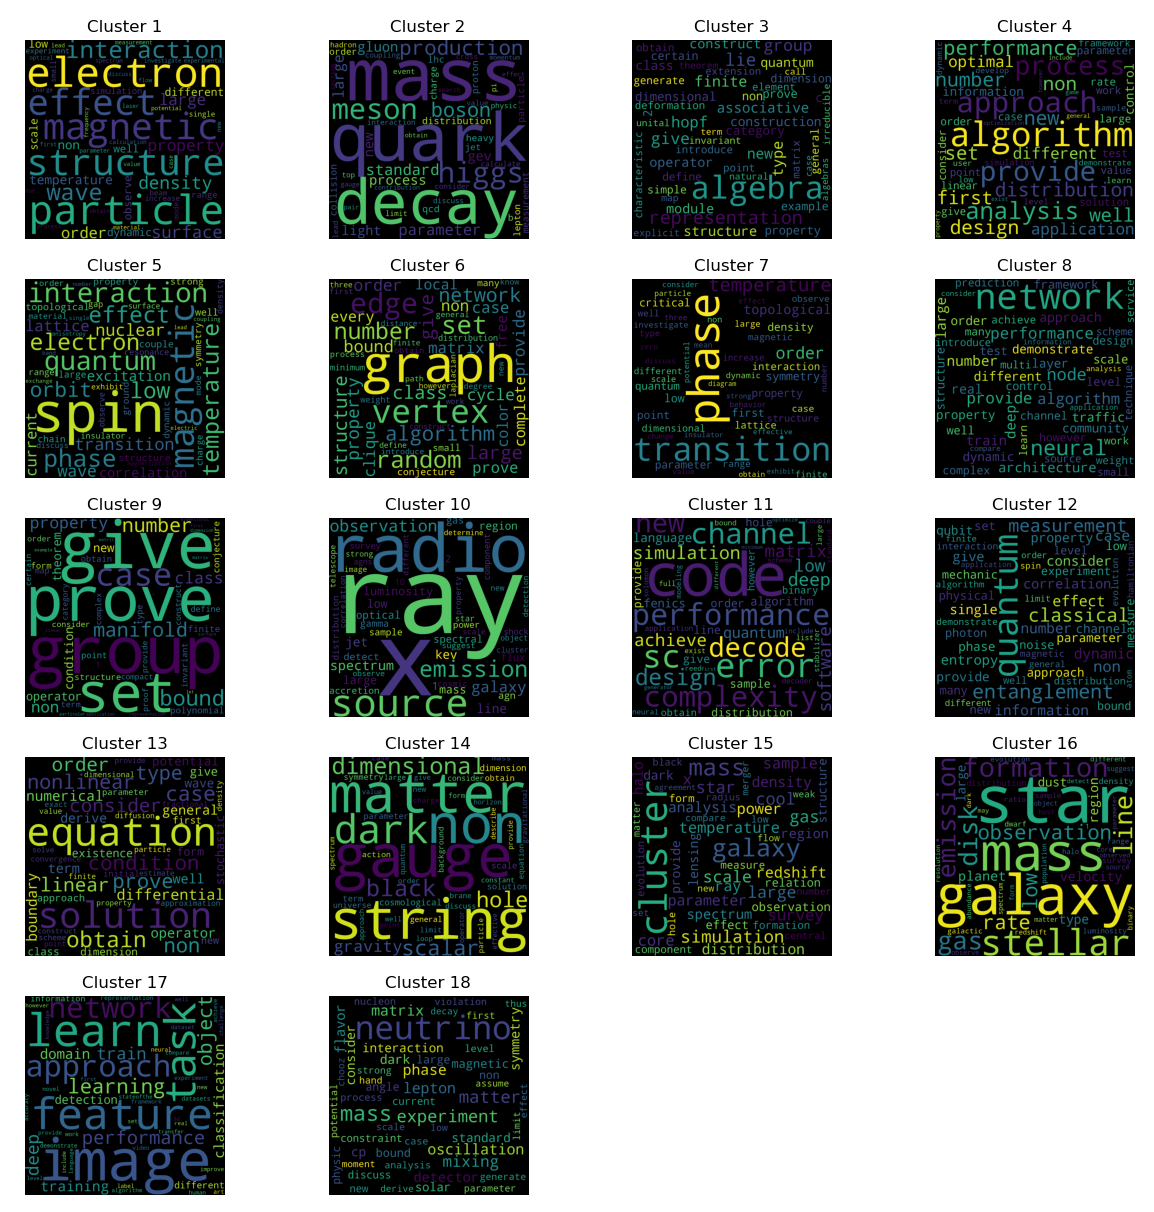

You will need `matplotlib`, and specifically the `add_subplot()` function to add subplots onto a figure generated with `pyplot.figure()` with a 5 x 4 grid i.e. the figure must have space for 20 subplots. You must generate word clouds using `generate_word_cloud()` for each cluster and plot them on each of the added subplots.

Fill in the function `plot_word_clouds()` below that takes as argument the K-tuple storing dictionaries of the top 50 words in each cluster, and plots the word cloud for all K clusters in one figure.

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
def plot_word_clouds(clustered_abstracts_top50: tuple):
    """
    Plot word clouds of all K abstract clusters.

    Parameters
    ----------
    clustered_abstracts_top50 : tuple
        Tuple of dictionaries of top 50 most occurring words in each of the K clusters.

    Returns
    -------
    None
    """
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud

    cols = 4
    rows = (len(clustered_abstracts_top50) + cols - 1) // cols
    fig = plt.figure(figsize=(10, 10))

    for cluster_id, word_dict in enumerate(clustered_abstracts_top50):
        print(f"Generating word cloud for Cluster {cluster_id + 1}")
        wordcloud = WordCloud(
            width=800, height=400, background_color="black", colormap="viridis"
        ).generate_from_frequencies(word_dict)
        ax = fig.add_subplot(rows, cols, cluster_id + 1)
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.axis("off")
        ax.set_title(f"Cluster {cluster_id + 1}", fontsize=14)

    plt.tight_layout()
    print("Displaying all word clouds...")
    plt.show()


Let's visualize our word cloud plots:

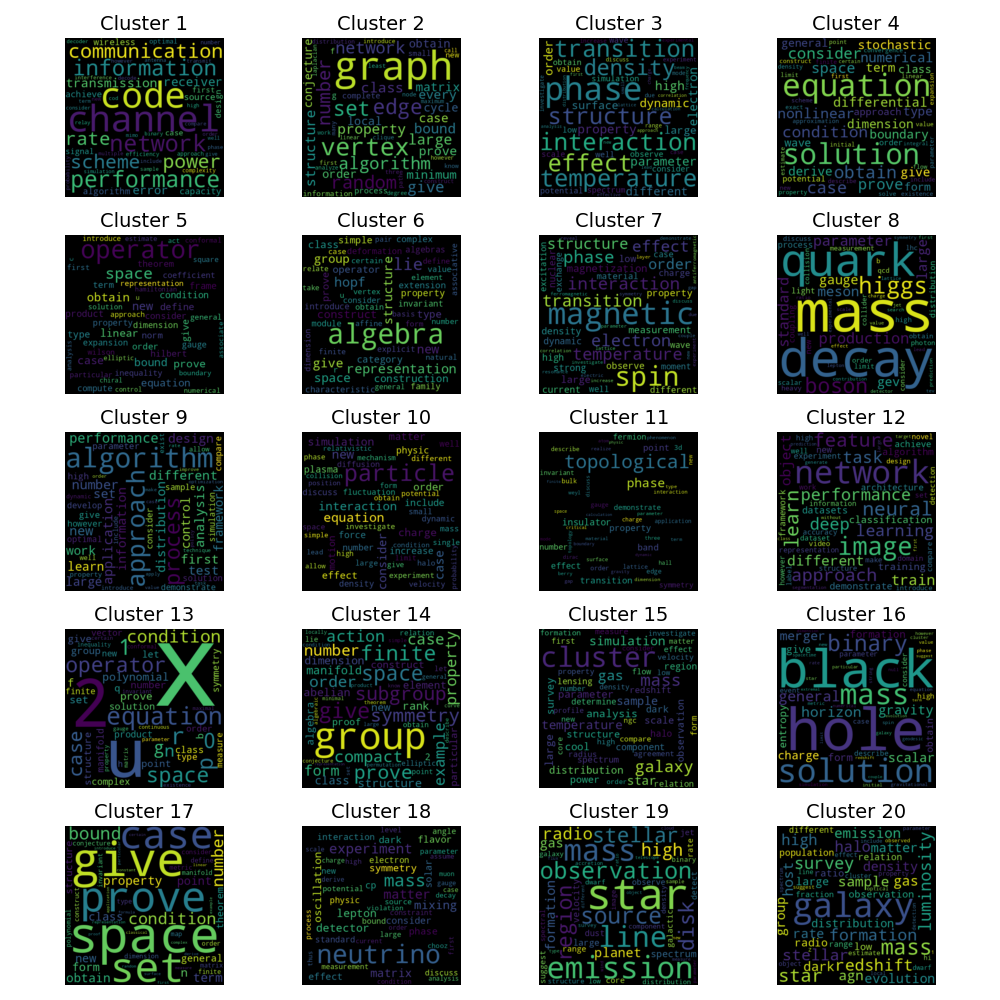

In [ ]:
plot_word_clouds(clustered_abstracts_top50)

Support for third party widgets will remain active for the duration of the session. To disable support:

Support for third party widgets will remain active for the duration of the session. To disable support:

Support for third party widgets will remain active for the duration of the session. To disable support:


<img src="https://upload.wikimedia.org/wikipedia/commons/0/02/Vraagteken.svg" width="50px" align="left" float="left" style="padding-left:30px;"/>
<br><br><br><br>

### Q8 : 3D Scatterplot Visualization [15%]

Another way to visualize our clusters is to obtain a labeled scatterplot of the data. However, we have 100 features for each abstract which makes it infeasible to visualize them with a simple plot. A common solution is to further reduce the dimensionality of the features to 3 or 2 dimensions for plotting. `sklearn.decomposition.PCA` is a class that implements Principal Components Analysis using Singular-Value Decomposition to identify and retain important feature components that cause the most variation in the data (A stack exchange answer about how it is different from `TruncatedSVD` [here](https://stats.stackexchange.com/a/239537)). Let's import the `PCA` class from `sklearn`:

In [ ]:
from sklearn.decomposition import PCA

 We will now use PCA to reduce the dimensionality of our feature matrix further down to 3 features and use them to produce a [3D scatter plot](https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html) figure. You will need to obtain labels for each abstract using the `KMeans` instance of the best clustering model obtained above and use it to assign colors to each point, and also use `processed_abstracts` to obtain the top 5 most frequent words in each cluster to use them as labels that will appear in the legend. The resulting figure should look something like this:




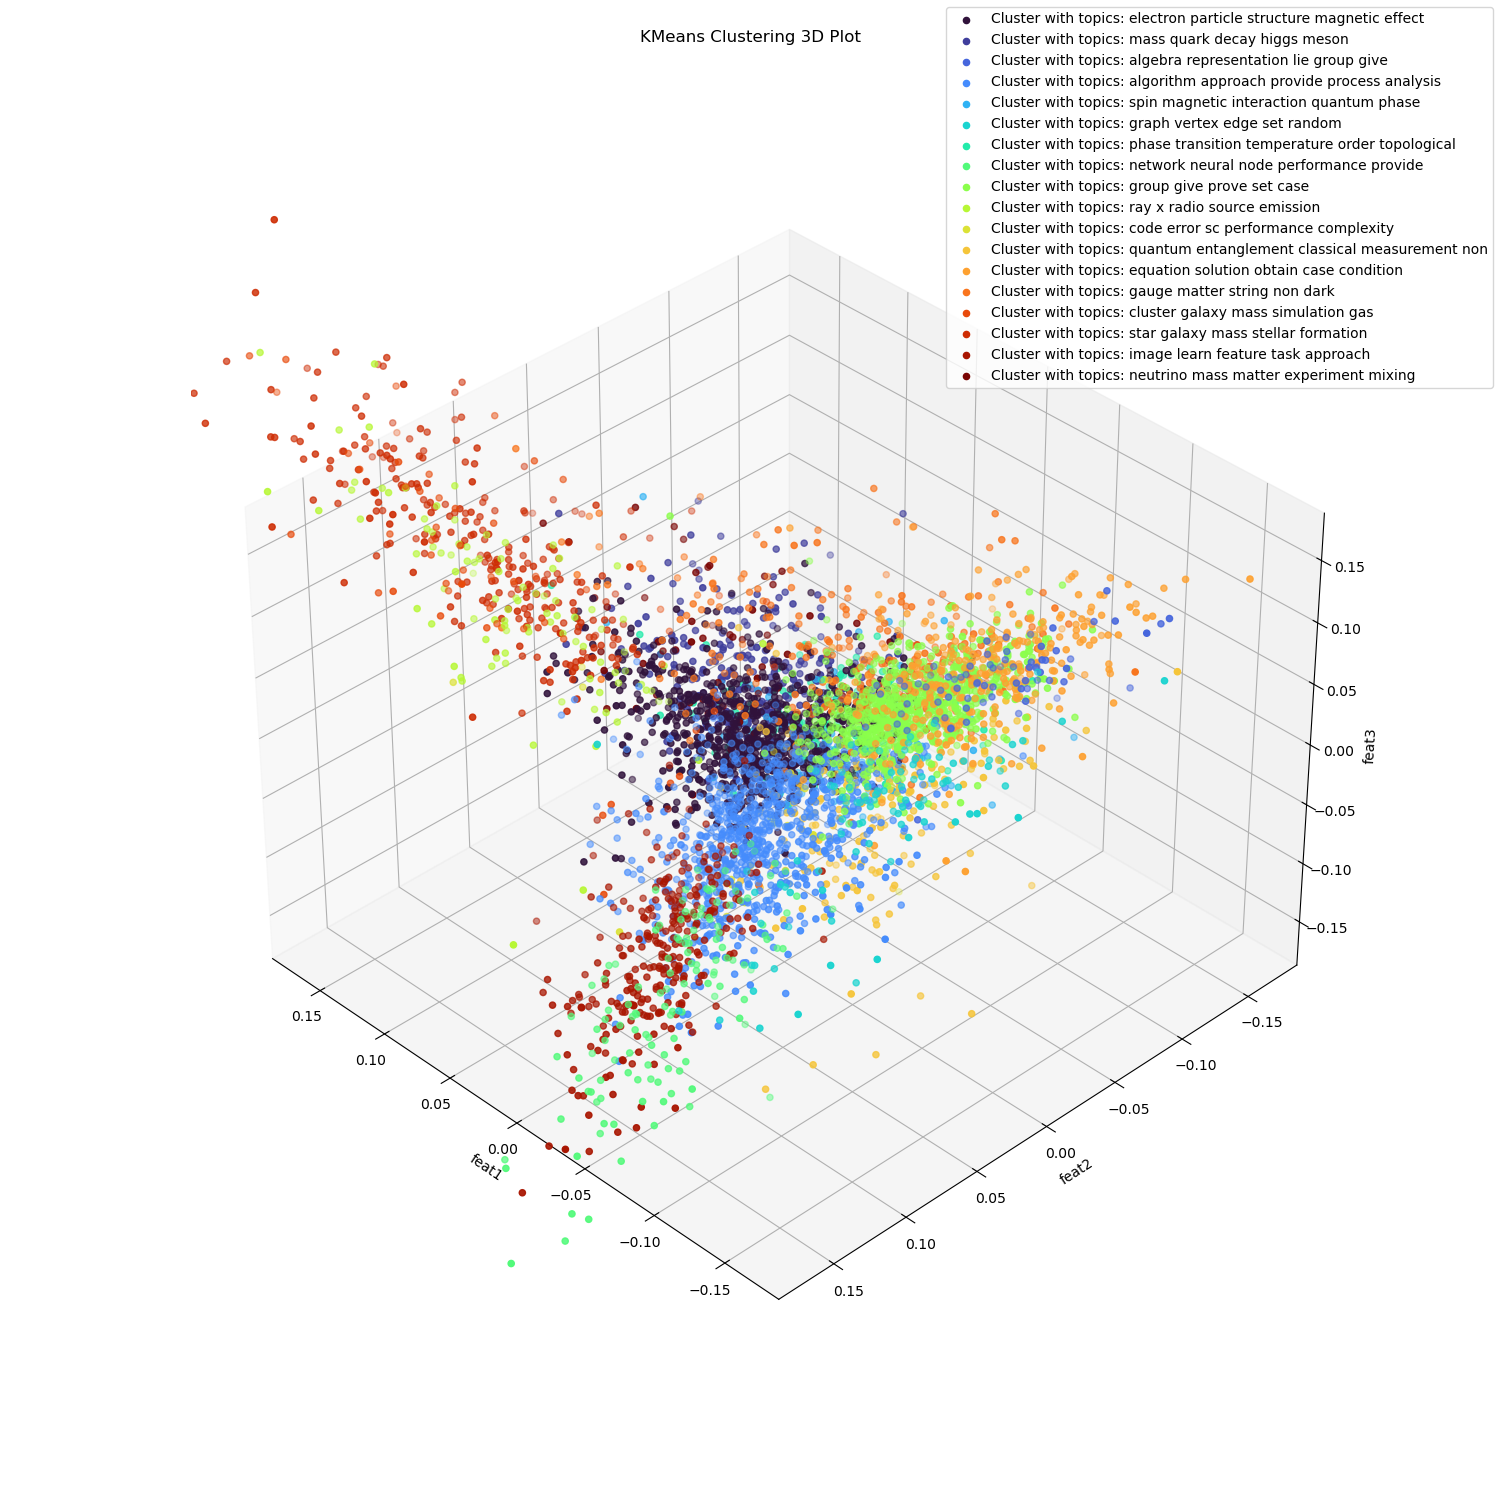

Fill in the function `clusters_3d_scatterplot()` below that takes as argument the abstracts feature matrix, the `KMeans` instance for the best clustering model we obtained above, a dataframe containing our abstracts in a column named `abstract`, and creates a scatter plot of the data in 3D with each point colored distinctly based on its assigned cluster.

**Note**: Set `figsize=[15,15]` and `cmap="turbo"` while plotting the figure. X,Y, and Z limits should be `[-0.18, +0.18]`, and location for the legend should be `loc="outside center right"`. Other features of the plot should be understood from the figure above.

To make the plot interactive, we need to install the package `ipympl` and set the macro `widget` before proceeding:

In [ ]:
!pip install ipympl
%matplotlib widget

In [ ]:

def clusters_3d_scatterplot(abstracts_feats:np.ndarray, clustering:KMeans, abstracts:pd.DataFrame):
    """
    Generate a 3D Scatterplot of the best K-Means clustering
    model using PCA

    Parameters
    ----------
    abstracts_feats : np.ndarray
        Feature matrix for abstracts data
    clustering:KMeans
        Instance of KMeans class
    abstracts:pd.DataFrame
        Dataframe containing a column
        'abstract'
    """
    # [Your Code Starts Here]
    pca = PCA(n_components=3)
    pca_features = pca.fit_transform(abstracts_feats)

    # Get cluster labels
    cluster_labels = clustering.labels_

    # Create the 3D scatter plot
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection="3d")

    # Scatter plot with cluster-based coloring
    scatter = ax.scatter(
        pca_features[:, 0],
        pca_features[:, 1],
        pca_features[:, 2],
        c=cluster_labels,
        cmap="tab20",  # Use a colormap supporting up to 20 clusters
        s=20,
        alpha=0.8
    )

    # Set plot limits and title
    ax.set_xlim(-0.18, 0.18)
    ax.set_ylim(-0.18, 0.18)
    ax.set_zlim(-0.18, 0.18)
    ax.set_title("KMeans Clustering 3D Plot", fontsize=12)

    # Add axis labels
    ax.set_xlabel("feat1", fontsize=10)
    ax.set_ylabel("feat2", fontsize=10)
    ax.set_zlabel("feat3", fontsize=10)

    # Generate top 5 frequent words for each cluster
    top_words = []
    for cluster in range(clustering.n_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_abstracts = abstracts.iloc[cluster_indices]['abstract']

        # Count word frequencies in abstracts of the cluster
        word_freq = {}
        for abstract in cluster_abstracts:
            # Ensure abstract is a string (join if it's a list of words)
            if isinstance(abstract, list):
                abstract = " ".join(abstract)  # Join the list of words into a string

            words = abstract.split()  # Split abstracts into words
            for word in words:
                word_freq[word] = word_freq.get(word, 0) + 1

        # Get top 5 most frequent words
        sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:5]
        top_words.append(", ".join(word for word, freq in sorted_words))

    # Ensure the legend has 20 elements (fill in placeholders if necessary)
    while len(top_words) < 20:
        top_words.append("No data")

    # Create legend labels
    legend_labels = [f"Cluster {i} with topics: {words}" for i, words in enumerate(top_words[:20])]

    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab20(i / 20), markersize=8) for i in range(20)]
    fig.legend(handles=legend_elements, labels=legend_labels, bbox_to_anchor=(1.05, 0.85), loc='upper left')

    plt.show()
    # [Your Code Ends Here]

Let's visualize our scatter plot:

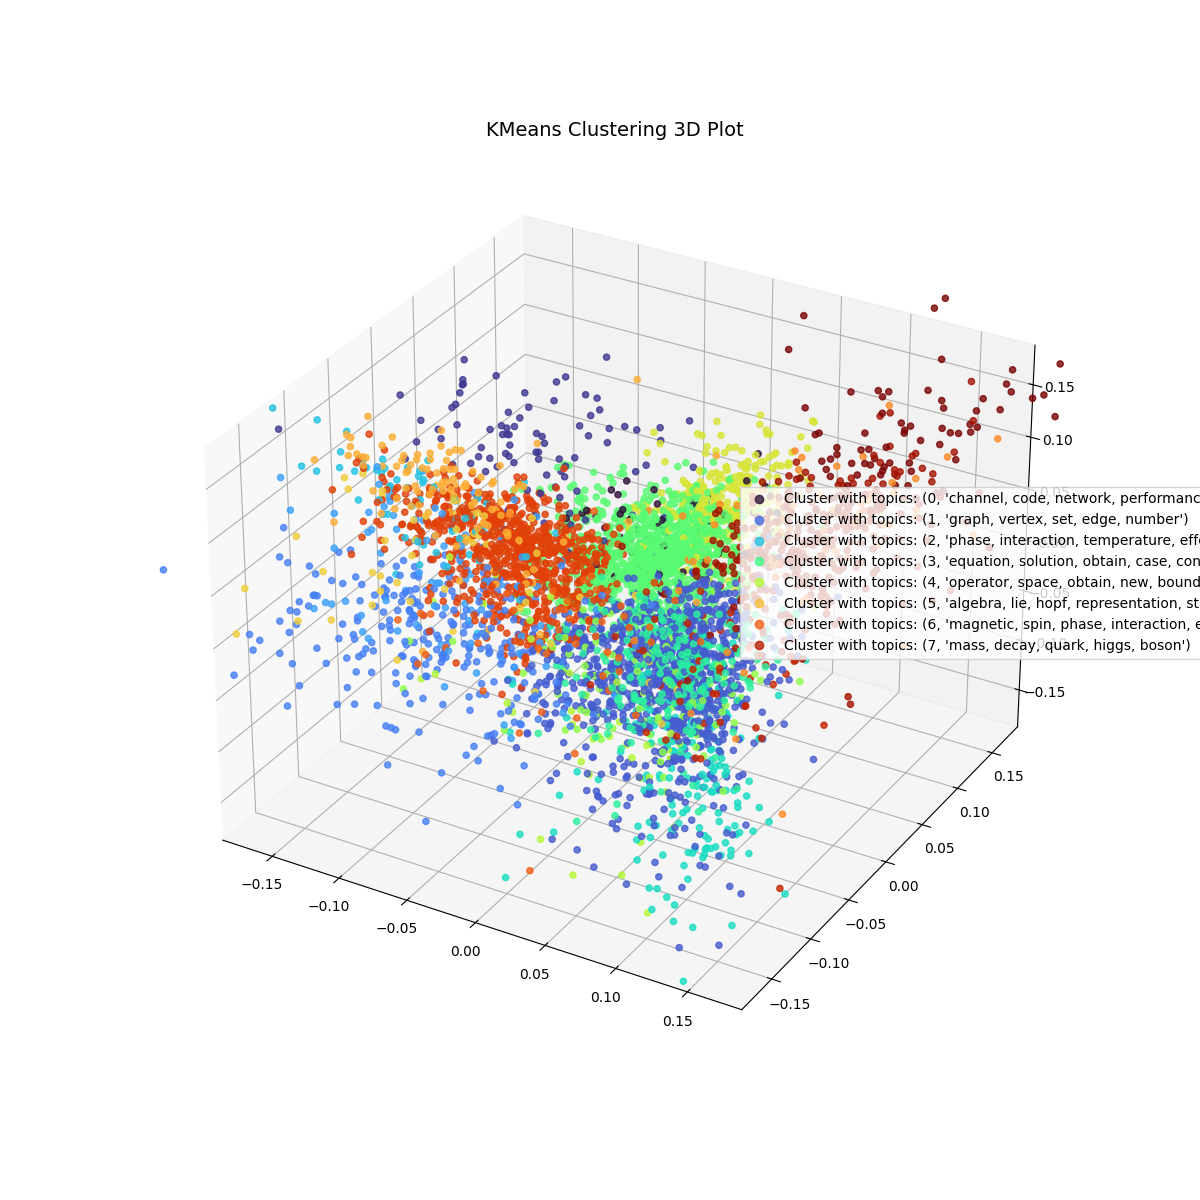

In [ ]:
clusters_3d_scatterplot(red_tfidf_feats, best_tfidf_clustering, processed_abstracts)



In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

<img src="https://upload.wikimedia.org/wikipedia/commons/0/02/Vraagteken.svg" width="50px" align="left" float="left" style="padding-left:30px;"/>
<br><br><br><br>

### Q9 : Written Questions [10%]


**Based on the generated word clouds, are you able to deduce what major scientific topics are prevalent in the data?**

\<Your Answer Here\>

**Based on the scatter plot and the word clouds, what do you make of the effectiveness of K-Means to model topics in ArXiv paper submissions using TF-IDF features? Are there any alternatives to TF-IDF that might work better here?**


\<Your Answer Here\>